> E01: train a trigram language model, i.e. take two characters as an input to predict the 3rd one. Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model?

I used counting method to build the trigram. The loss drop from `2.476470470428467` to `2.092747449874878`, which is a good improvement.

> E02: split up the dataset randomly into 80% train set, 10% dev set, 10% test set. Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?

|  | train | test | dev |
| --- | --- | --- | --- |
| bigram | `2.4550743103027344` | `2.454676628112793` | `2.4552478790283203` |
| bigram_nn | `2.4748518466949463` | `2.4748964309692383`| `2.474271774291992` |
| trigram | `2.095414876937866` | `2.1312243938446045` | `2.120994806289673` |
| trigram_nn | `2.398813486099243` | `2.4096901416778564`| `2.402540683746338` |

> E03: use the dev set to tune the strength of smoothing (or regularization) for the trigram model - i.e. try many possibilities and see which one works best based on the dev set loss. What patterns can you see in the train and dev set loss as you tune this strength? Take the best setting of the smoothing and evaluate on the test set once and at the end. How good of a loss do you achieve?

> E04: we saw that our 1-hot vectors merely select a row of W, so producing these vectors explicitly feels wasteful. Can you delete our use of F.one_hot in favor of simply indexing into rows of W?

> E05: look up and use F.cross_entropy instead. You should achieve the same result. Can you think of why we'd prefer to use F.cross_entropy instead?

> E06: meta-exercise! Think of a fun/interesting exercise and complete it.

# Data loading

In [1]:
words = open('../../../data/names.txt', 'r').read().splitlines()

In [2]:
words[:10], len(words)

(['emma',
  'olivia',
  'ava',
  'isabella',
  'sophia',
  'charlotte',
  'mia',
  'amelia',
  'harper',
  'evelyn'],
 32033)

In [3]:
import torch

g = torch.Generator().manual_seed(2147483647)
trainset, devset, testset = torch.utils.data.random_split(words, [0.8, 0.1, 0.1], g)

In [4]:
len(trainset), len(devset), len(testset)

(25627, 3203, 3203)

# Trigram

In [5]:
class Trigram:
    def loaddata(self, dataset):
        self.dataset = dataset

    def count(self):
        self.gram = {}

        for w in self.dataset:
            chs = ['<S>'] + list(w) + ['<E>']

            for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
                trigram = (ch1, ch2, ch3)
                self.gram[trigram] = self.gram.get(trigram, 0) + 1

        chars = sorted(list(set(''.join(trainset))))
        self.stoi = {s:i+1 for i,s in enumerate(chars)}
        self.stoi['.'] = 0
        self.itos = {i:s for s,i in self.stoi.items()}

    def prob(self):
        self.N = torch.zeros((27 * 27, 27), dtype=torch.int32)

        for w in trainset:
            chs = ['.'] + list(w) + ['.']
            
            for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
                ix1 = self.stoi[ch1]
                ix2 = self.stoi[ch2]
                ix3 = self.stoi[ch3]
                self.N[ix1 * 27 + ix2, ix3] += 1

        self.P = (self.N + 1).float()
        self.P /= self.P.sum(1, keepdim=True)

    def sample(self, num):
        g = torch.Generator().manual_seed(2147483647)

        for i in range(num):
            out = []

            # start token
            N_start = self.N[:27, :].sum(1)
            p_start = N_start / N_start.sum()
            p_start.sum()

            ix = torch.multinomial(p_start, num_samples=1, replacement=True, generator=g).item()
            ix1 = ix // 27
            ix2 = ix - ix1 * 27
            
            # continue token
            while True:
                p = self.P[ix]

                ix1 = ix2
                ix2 = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()

                ix = 27 * ix1 + ix2
                
                out.append(self.itos[ix2])
                
                if ix2 == 0:
                    break
                
            print(''.join(out))

    def eval(self, dataset):
        log_likelihood = 0.0
        n = 0

        for w in dataset:
        # for w in ["andrejq"]:
            chs = ['.'] + list(w) + ['.']
            
            for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
                ix1 = self.stoi[ch1]
                ix2 = self.stoi[ch2]
                ix3 = self.stoi[ch3]

                prob = self.P[27 * ix1 + ix2, ix3]
                logprob = torch.log(prob)
                log_likelihood += logprob
                n += 1

        print(f'{log_likelihood=}')
        nll = -log_likelihood
        print(f'{nll=}')
        print(f'{nll/n}')

In [6]:
import matplotlib.pyplot as plt

def draw_matrix(matrix, aspect_ratio = 1):
    plt.figure(figsize=(5, 5))
    plt.imshow(matrix, cmap='Blues')
    plt.gca().set_aspect(aspect_ratio)

## Trigram implement

In [7]:
trigram = Trigram()
trigram.loaddata(trainset)
trigram.count()
trigram.prob()

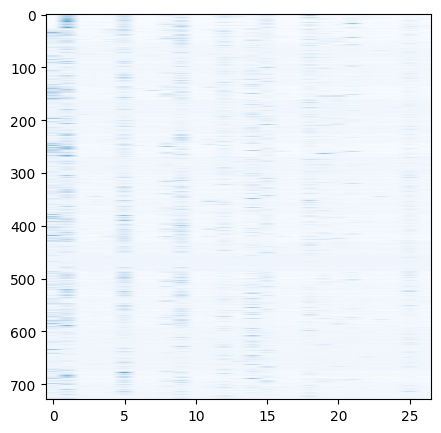

In [8]:
draw_matrix(trigram.P, 1/27)

In [9]:
trigram.sample(5)

unide.
anasid.
relay.
din.
airritoper.


In [10]:
print('='*50 + '\ntrain\n' + '-'*50)
trigram.eval(trainset)

print('='*50 + '\ndev\n' + '-'*50)
trigram.eval(devset)

print('='*50 + '\ntest\n' + '-'*50)
trigram.eval(testset)

train
--------------------------------------------------
log_likelihood=tensor(-328904.7188)
nll=tensor(328904.7188)
2.095414876937866
dev
--------------------------------------------------
log_likelihood=tensor(-41543.9570)
nll=tensor(41543.9570)
2.1312243938446045
test
--------------------------------------------------
log_likelihood=tensor(-41690.2734)
nll=tensor(41690.2734)
2.120994806289673


# Bigram

In [11]:
class Bigram(Trigram):
    def count(self):
        self.gram = {}

        for w in self.dataset:
            chs = ['<S>'] + list(w) + ['<E>']

            for ch1, ch2 in zip(chs, chs[1:]):
                bigram = (ch1, ch2)
                self.gram[bigram] = self.gram.get(bigram, 0) + 1

        chars = sorted(list(set(''.join(self.dataset))))
        self.stoi = {s:i+1 for i,s in enumerate(chars)}
        self.stoi['.'] = 0
        self.itos = {i:s for s,i in self.stoi.items()}

    def prob(self):
        self.N = torch.zeros((27, 27), dtype=torch.int32)

        for w in trainset:
            chs = ['.'] + list(w) + ['.']
            
            for ch1, ch2 in zip(chs, chs[1:]):
                ix1 = self.stoi[ch1]
                ix2 = self.stoi[ch2]
                self.N[ix1, ix2] += 1

        self.P = (self.N + 1).float()
        self.P /= self.P.sum(1, keepdim=True)

    def sample(self, num):
        g = torch.Generator().manual_seed(2147483647)

        for i in range(num):
            out = []

            # start token
            p_start = self.P[0]
            ix = torch.multinomial(p_start, num_samples=1, replacement=True, generator=g).item()
            
            # continue token
            while True:
                p = self.P[ix]
                ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
                out.append(self.itos[ix])
                
                if ix == 0:
                    break
                
            print(''.join(out))

    def eval(self, dataset):
        log_likelihood = 0.0
        n = 0

        for w in dataset:
        # for w in ["andrejq"]:
            chs = ['.'] + list(w) + ['.']
            
            for ch1, ch2 in zip(chs, chs[1:]):
                ix1 = self.stoi[ch1]
                ix2 = self.stoi[ch2]

                prob = self.P[ix1, ix2]
                logprob = torch.log(prob)
                log_likelihood += logprob
                n += 1

        print(f'{log_likelihood=}')
        nll = -log_likelihood
        print(f'{nll=}')
        print(f'{nll/n}')

## Bigram implement

In [12]:
bigram = Bigram()
bigram.loaddata(trainset)
bigram.count()
bigram.prob()

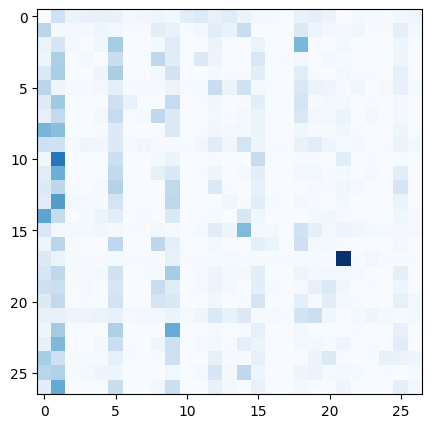

In [13]:
draw_matrix(bigram.P)

In [14]:
bigram.sample(5)

unide.
anasah.
.
ony.
.


In [15]:
print('='*50 + '\ntrain\n' + '-'*50)
bigram.eval(trainset)

print('='*50 + '\ndev\n' + '-'*50)
bigram.eval(devset)

print('='*50 + '\ntest\n' + '-'*50)
bigram.eval(testset)

train
--------------------------------------------------
log_likelihood=tensor(-448274.4688)
nll=tensor(448274.4688)
2.4550743103027344
dev
--------------------------------------------------
log_likelihood=tensor(-55711.3398)
nll=tensor(55711.3398)
2.454676628112793
test
--------------------------------------------------
log_likelihood=tensor(-56124.5117)
nll=tensor(56124.5117)
2.4552478790283203


# Bigram neural network

In [71]:
import torch.nn.functional as F

class Bigram_NN:
    def __init__(self):
        g = torch.Generator().manual_seed(2147483647)
        self.W = torch.randn((27, 27), generator=g, requires_grad=True)

    def loaddata(self, dataset):
        chars = sorted(list(set(''.join(dataset))))
        self.stoi = {s:i+1 for i,s in enumerate(chars)}
        self.stoi['.'] = 0
        self.itos = {i:s for s,i in self.stoi.items()}

        xs, ys = [], []

        for w in dataset:
            chs = ['.'] + list(w) + ['.']

            for ch1, ch2 in zip(chs, chs[1:]):
                ix1 = self.stoi[ch1]
                ix2 = self.stoi[ch2]
                xs.append(ix1)
                ys.append(ix2)

        self.xs = torch.tensor(xs)
        self.ys = torch.tensor(ys)

    def forward_pass(self, xs):
        xenc = F.one_hot(xs, num_classes=27).float()
        logits = xenc @ self.W
        counts = logits.exp()
        probs = counts / counts.sum(1, keepdims=True)

        return probs
    
    def train(self, epoch, is_print = True, is_draw = False):
        if is_draw:
            loss_ls = []

        for k in range(epoch):
            self.W.grad = None

            probs = self.forward_pass(self.xs)
            loss = -probs[torch.arange(self.xs.nelement()), self.ys].log().mean() + 0.01*(self.W**2).mean()

            if is_print:
                print('epoch: {} loss: {}'.format(k, loss.item()))

            if is_draw:
                loss_ls.append(loss.item())
            
            loss.backward()

            self.W.data += -50 * self.W.grad

        if is_draw:
            plt.plot(loss_ls)

            plt.title('loss curve')
            plt.grid(linestyle='--')
            plt.xlabel('epoches')
            plt.ylabel('mean negative log-likelihood')

    def sample(self, num):
        g = torch.Generator().manual_seed(2147483647)

        for i in range(num):
            out = []
            ix = 0
            
            # continue token
            while True:
                p = self.forward_pass(torch.tensor([ix, ]))[0]
                ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
                out.append(self.itos[ix])
                
                if ix == 0:
                    break
                
            print(''.join(out))

    def eval(self, dataset, is_print = True):
        log_likelihood = 0.0
        n = 0

        xs, ys = [], []

        for w in dataset:
            chs = ['.'] + list(w) + ['.']

            for ch1, ch2 in zip(chs, chs[1:]):
                ix1 = self.stoi[ch1]
                ix2 = self.stoi[ch2]
                xs.append(ix1)
                ys.append(ix2)

        xs = torch.tensor(xs)
        ys = torch.tensor(ys)
        probs = self.forward_pass(xs)
        log_likelihood = probs[torch.arange(xs.nelement()), ys].log().sum()
        nll = -log_likelihood
        mnll = nll / len(xs)

        if is_print:
            print(f'{log_likelihood=}')
            print(f'{nll=}')
            print(f'{mnll}')

        return mnll

## Bigram neural network implement

In [72]:
bigram_nn = Bigram_NN()
bigram_nn.loaddata(trainset)

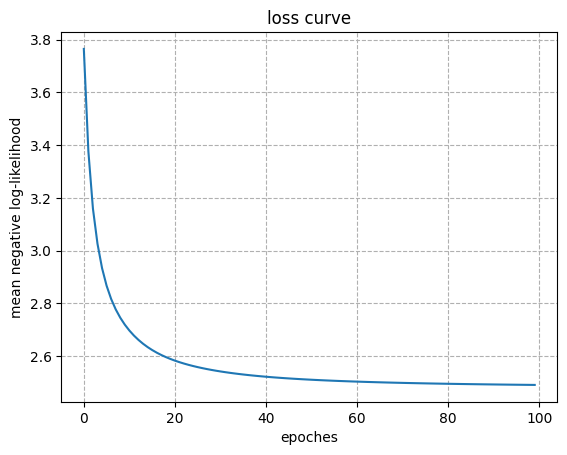

In [73]:
bigram_nn.train(100, is_print=False, is_draw=True)

In [74]:
bigram_nn.sample(5)

junide.
janasah.
p.
cfay.
a.


In [75]:
print('='*50 + '\ntrain\n' + '-'*50)
bigram_nn.eval(trainset)

print('='*50 + '\ndev\n' + '-'*50)
bigram_nn.eval(devset)

print('='*50 + '\ntest\n' + '-'*50)
bigram_nn.eval(testset)

train
--------------------------------------------------
log_likelihood=tensor(-451925.0938, grad_fn=<SumBackward0>)
nll=tensor(451925.0938, grad_fn=<NegBackward0>)
2.4750678539276123
dev
--------------------------------------------------
log_likelihood=tensor(-56168.5039, grad_fn=<SumBackward0>)
nll=tensor(56168.5039, grad_fn=<NegBackward0>)
2.4748194217681885
test
--------------------------------------------------
log_likelihood=tensor(-56557.5391, grad_fn=<SumBackward0>)
nll=tensor(56557.5391, grad_fn=<NegBackward0>)
2.474191188812256


tensor(2.4742, grad_fn=<DivBackward0>)

# Trigram neural network

In [65]:
class Trigram_NN(Bigram_NN):
    def __init__(self):
        g = torch.Generator().manual_seed(2147483647)
        self.W = torch.randn((27 * 27, 27), generator=g, requires_grad=True)

    def loaddata(self, dataset):
        chars = sorted(list(set(''.join(dataset))))
        self.stoi = {s:i+1 for i,s in enumerate(chars)}
        self.stoi['.'] = 0
        self.itos = {i:s for s,i in self.stoi.items()}

        xs, ys = [], []

        for w in dataset:
            chs = ['.'] + list(w) + ['.']

            for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
                ix1 = self.stoi[ch1]
                ix2 = self.stoi[ch2]
                ix3 = self.stoi[ch3]
                xs.append(27 * ix1 + ix2)
                ys.append(ix3)

        self.xs = torch.tensor(xs)
        self.ys = torch.tensor(ys)

    def forward_pass(self, xs):
        xenc = F.one_hot(xs, num_classes=27 * 27).float()
        logits = xenc @ self.W
        counts = logits.exp()
        probs = counts / counts.sum(1, keepdims=True)

        return probs

    def sample(self, num):
        g = torch.Generator().manual_seed(2147483647)

        for i in range(num):
            out = []
            ixs = self.xs[self.xs < 27]
            idx_rand = torch.randint(len(ixs), (1, ))
            ix = ixs[idx_rand]
            
            # continue token
            while True:
                p = self.forward_pass(torch.tensor([ix, ]))[0]
                ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
                out.append(self.itos[ix])
                
                if ix == 0:
                    break
                
            print(''.join(out))

    def eval(self, dataset, is_print = True):
        log_likelihood = 0.0
        n = 0

        xs, ys = [], []

        for w in dataset:
            chs = ['.'] + list(w) + ['.']

            for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
                ix1 = self.stoi[ch1]
                ix2 = self.stoi[ch2]
                ix3 = self.stoi[ch3]
                xs.append(27 * ix1 + ix2)
                ys.append(ix3)

        xs = torch.tensor(xs)
        ys = torch.tensor(ys)
        probs = self.forward_pass(xs)
        log_likelihood = probs[torch.arange(xs.nelement()), ys].log().sum()
        nll = -log_likelihood
        mnll = nll / len(xs)

        if is_print:
            print(f'{log_likelihood=}')
            print(f'{nll=}')
            print(f'{mnll}')

        return mnll

## Trigram neural network implement

In [66]:
trigram_nn = Trigram_NN()
trigram_nn.loaddata(trainset)

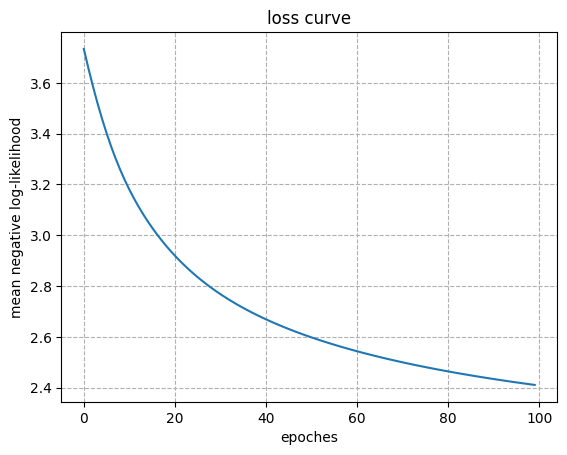

In [67]:
trigram_nn.train(100, is_print=False, is_draw=True)

In [63]:
trigram_nn.sample(5)

auwidediliasazaufrfaywelinavshinitolemasarezavilanaauyamileviasadbdainrwistadsejainaytarolofavmumaryfoltumempfyasufahamanirhoraayaezanarajaabrinedemiismayfinwanaasnhaviihofbrohadgasfbradavilu.
elemalarhatiryareli.
isamemeromjemujemaluuywyalpchacararorodkhufrottanapayasbrlahauiqlavmpocalihamimayawatrf.
vidamalevshatikemialoevmalaushemafabjanemadanilaryawtruizaodaidadzeolialilpargraitezraleliqqvywhqelvavirivisbrhaufademilwtrasabbrinalixalipixtelusogrecfdadecanavmankesoranajedayaraanokdabrelihanazyhdabraduolwiasatelytilabusidasavedjayalinevisqlasppakatalalokamalemadmanistfalamadedihavigaouzidiyqyvixi.
uzisuyaglivnalgushamofrafrlaglyuizluyhanotraryalirsoirevihaipalwxwvjapashiadadelnancacvatavayaelashbrlajopaluyalihwisjbiluzanarabbrhadisauyanoleofvwqjadeucalazyarhavroliqocadayraufbraqwouywytozazazadadanoufdevvinasuleleconakanilazastanitcorhanisemytelwwlixilemcharekanaljagkinemfinafaminayaularovyab.


In [70]:
print('='*50 + '\ntrain\n' + '-'*50)
trigram_nn.eval(trainset)

print('='*50 + '\ndev\n' + '-'*50)
trigram_nn.eval(devset)

print('='*50 + '\ntest\n' + '-'*50)
trigram_nn.eval(testset)

train
--------------------------------------------------
log_likelihood=tensor(-376521.3125, grad_fn=<SumBackward0>)
nll=tensor(376521.3125, grad_fn=<NegBackward0>)
2.3987748622894287
dev
--------------------------------------------------
log_likelihood=tensor(-46971.6562, grad_fn=<SumBackward0>)
nll=tensor(46971.6562, grad_fn=<NegBackward0>)
2.40966796875
test
--------------------------------------------------
log_likelihood=tensor(-47224.1367, grad_fn=<SumBackward0>)
nll=tensor(47224.1367, grad_fn=<NegBackward0>)
2.4025304317474365


tensor(2.4025, grad_fn=<DivBackward0>)